Right click on the shared folder icon, choose -> create shorcut and move it to your MyDrive/ folder

In [ ]:
using_colab = True

if using_colab:
    from google.colab import drive
    import torch
    import torchvision

    drive.mount('/content/drive')

    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    !pip install opencv-python matplotlib numpy pandas natsort accelerate
    !pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p data

    !cp "/content/drive/MyDrive/Projekt IO/imagesTr-jpeg.zip" data/
    !cp "/content/drive/MyDrive/Projekt IO/labelsTr-bmp.zip" data/

    !unzip -d data "data/imagesTr-jpeg.zip"
    !unzip -d data "data/labelsTr-bmp.zip"

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from natsort import natsorted
from PIL import Image

from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
else:
    print("Training should not be done on CPU")

using device: cuda


In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
#match the videos to labels (i could have been done blindly without dataframe)
#but this ensures that all the files are present and is more maintainable
import pandas as pd
# Define directories
video_dir = "/content/data/imagesTr-jpeg"
masks_dir = "/content/data/labelsTr-bmp"

# Initialize an empty DataFrame
train_df = pd.DataFrame(columns=["image", "annotation"])

# Loop through each patient directory (e.g., BRATS_001, BRATS_002)
for image_id in os.listdir(video_dir):
    image_path = os.path.join(video_dir, image_id)
    label_path = os.path.join(masks_dir, image_id, "modality_1")

    # Ensure both image and label directories exist for the patient
    if not os.path.isdir(image_path) or not os.path.isdir(label_path):
        continue

    # Loop through modalities (from modality_1 to modality_4)
    for modality in range(1, 5):
        modality_dir = f"modality_{modality}"
        modality_path = os.path.join(image_path, modality_dir)

        # Check if modality path exists in images
        if not os.path.isdir(modality_path):
            continue

        # Loop through each scan axis (x, y, z)
        for axis in ['x', 'y', 'z']:
            image_scan_path = os.path.join(modality_path, f"scans_{axis}")
            label_scan_path = os.path.join(label_path, f"scans_{axis}")

            # Only add the row if both image and label paths exist
            if os.path.exists(image_scan_path) and os.path.exists(label_scan_path):
                # Create a temporary DataFrame for the new row
                new_row = pd.DataFrame({
                    "image": [image_scan_path],
                    "annotation": [label_scan_path]
                })

                # Concatenate the new row to the main DataFrame
                train_df = pd.concat([train_df, new_row], ignore_index=True)

# Display the first few rows to confirm the structure
print("Training DataFrame:")
print(train_df.head())
print("Total entries in training data:", len(train_df))
data_dir = r"/content/data"
train_df.to_csv(os.path.join(data_dir, "processed_train.csv"), index=False)

Training DataFrame:
                                               image  \
0  /content/data/imagesTr-jpeg/BRATS_381/modality...   
1  /content/data/imagesTr-jpeg/BRATS_381/modality...   
2  /content/data/imagesTr-jpeg/BRATS_381/modality...   
3  /content/data/imagesTr-jpeg/BRATS_381/modality...   
4  /content/data/imagesTr-jpeg/BRATS_381/modality...   

                                          annotation  
0  /content/data/labelsTr-bmp/BRATS_381/modality_...  
1  /content/data/labelsTr-bmp/BRATS_381/modality_...  
2  /content/data/labelsTr-bmp/BRATS_381/modality_...  
3  /content/data/labelsTr-bmp/BRATS_381/modality_...  
4  /content/data/labelsTr-bmp/BRATS_381/modality_...  
Total entries in training data: 5808


In [7]:
def select_random_points(mask, label):
    """
    Function to select random points within the mask for a given label.
    """
    points = np.column_stack(np.where(mask == 1))  # Find the points where mask is 1
    num_points = len(points)

    if num_points == 0:
        return [], []  # No points found, so returning empty lists

    selected_indices = np.random.choice(num_points, size=min(1, num_points), replace=False)
    selected_points = points[selected_indices]

    points = [[x, y] for x, y in selected_points]
    labels = [label for _ in selected_points]
    return points, labels


In [19]:
def read_batch(data, idx=None, max_frames=16):
    """
    For a given index, load the image and its corresponding mask and points.
    """
    if idx == None:
      idx = np.random.randint(len(data))
    ent = data.iloc[idx]

    # Construct paths for the image and corresponding mask frames
    img_dir = ent["image"]
    mask_dir = ent["annotation"]

    # Load all frame files in the folder and sort by filename
    img_frames = natsorted(os.listdir(img_dir))
    msk_frames = natsorted(os.listdir(mask_dir))

    # Strip extensions to find matching base filenames
    img_basenames = {os.path.splitext(f)[0]: f for f in img_frames}
    mask_basenames = {os.path.splitext(f)[0]: f for f in msk_frames}

    # Find the intersection of base filenames
    matching_frames = natsorted(set(img_basenames.keys()).intersection(mask_basenames.keys()))


    # Initialize lists
    image_frames = []
    mask_frames = []
    random_points_all = []
    labels_for_points = []

    for frame_name in matching_frames:
        img_path = os.path.join(img_dir, (frame_name + ".jpeg"))
        mask_path = os.path.join(mask_dir, (frame_name + ".bmp"))

        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        ann_map = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        if img is None or ann_map is None:
            print(f"Error: Could not read image or mask from path {img_path} or {mask_path}")
            continue

        mask_channel_1 = np.where(ann_map == 255, 1, 0)
        mask_channel_2 = np.where(ann_map == 170, 1, 0)
        mask_channel_3 = np.where(ann_map == 85, 1, 0)

        # Generate random points and labels for each mask channel
        random_points_1, labels_1 = select_random_points(mask_channel_1, 1)
        random_points_2, labels_2 = select_random_points(mask_channel_2, 2)
        random_points_3, labels_3 = select_random_points(mask_channel_3, 3)

        random_points = random_points_1 + random_points_2 + random_points_3
        labels = labels_1 + labels_2 + labels_3

        # Warunek sprawdzający, czy znaleziono przynajmniej 1 punkt
        if len(random_points) == 0:
            print(f"No points found for frame: {frame_name}")
            continue  # Pomiń ten obraz, jeśli nie znaleziono punktów

        if len(random_points) != len(labels):
            print("Mismatch in the size of points and labels")
            continue  # Skip this frame or handle it differently

        # Combine all random points and labels
        random_points_all.append(random_points)
        labels_for_points.append(labels)

        image_frames.append(img)

        # Combine the masks for the current frame using the given weights
        mask_frame = 255 * mask_channel_1 + 170 * mask_channel_2 + 85 * mask_channel_3
        mask_frames.append(mask_frame)

    # Convert to numpy arrays
    image_frames = np.array(image_frames)
    mask_frames = np.array(mask_frames)

    # Ensure the batch has the exact size (add padding if needed)
    if len(image_frames) < max_frames:
        image_frames = np.pad(image_frames, ((0, max_frames - len(image_frames)), (0, 0), (0, 0), (0, 0)), mode='constant')
        mask_frames = np.pad(mask_frames, ((0, max_frames - len(mask_frames)), (0, 0), (0, 0)), mode='constant')

    return image_frames[:max_frames], mask_frames[:max_frames], random_points_all, labels_for_points


In [9]:
def visualize_data(image_frames, mask_frames, random_points_all, labels_for_points, idx=None):
    """
    Visualize an image, its segmentation mask, and the random points.
    """
    if idx is None:
        idx = np.random.randint(len(image_frames))  # Choose a random index if not provided

    dot_size = 5

    # Visualization
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title('Original Image at idx ' + str(idx))
    plt.imshow(image_frames[idx], cmap = 'gray')
    plt.axis('off')

    # Segmentation Mask (binary_mask)
    plt.subplot(1, 3, 2)
    plt.title('Binarized Mask at idx ' + str(idx))
    plt.imshow(mask_frames[idx], cmap='gray')
    plt.axis('off')

    # Mask with Points in Different Colors
    plt.subplot(1, 3, 3)
    plt.title(f'Binarized Mask at idx {idx} with random points')
    plt.imshow(mask_frames[idx], cmap='gray')

    label_color_map = {
        1: 'red',
        2: 'orange',
        3: 'yellow',
        4: 'blue',
        5: 'green',
    }

    label_color_map = {1: 'red', 2: 'orange', 3: 'yellow'}
    for points_idx, point in enumerate(random_points_all[idx]):
        plt.scatter(point[1], point[0], color=label_color_map.get(labels_for_points[idx][points_idx], 'black'), s=dot_size)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

(32, 240, 240, 3)
(32, 240, 240)
92
92
[[110, 95], [102, 93]]


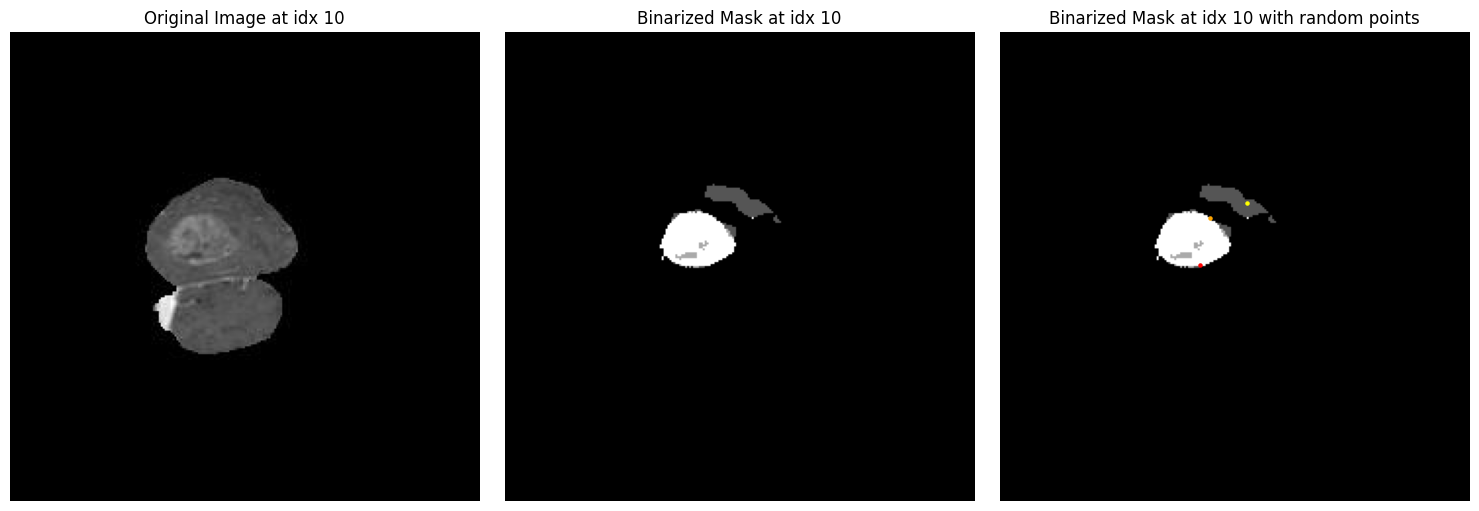

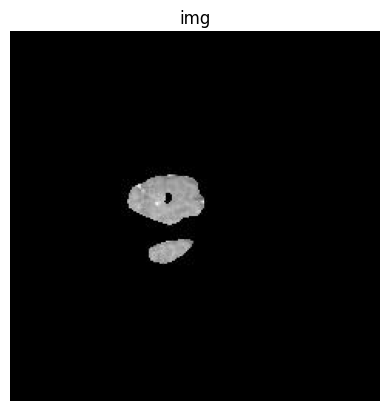

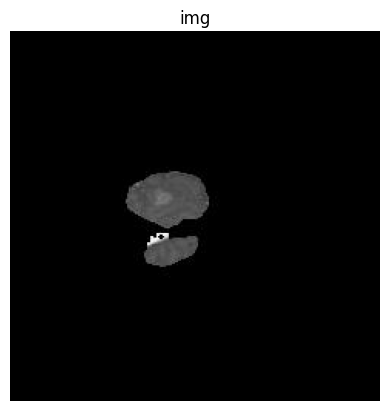

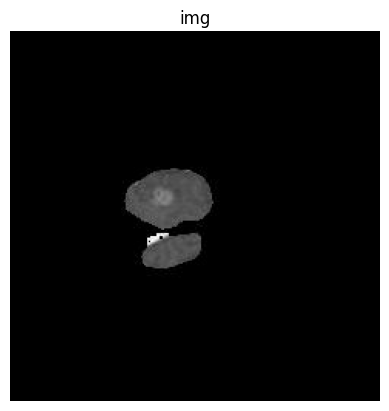

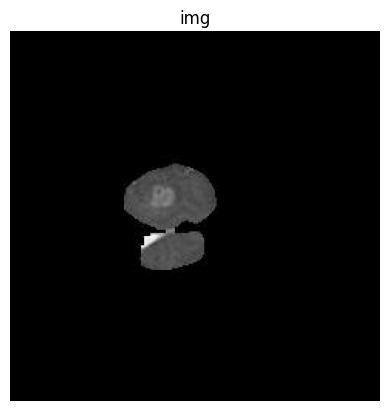

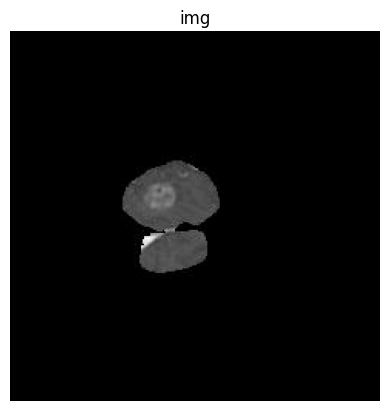

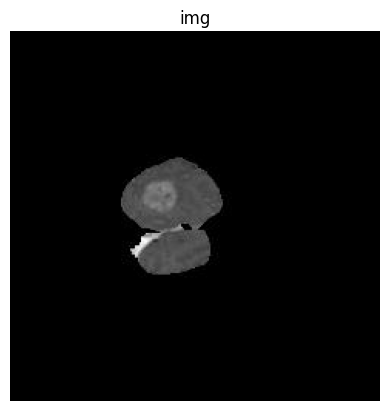

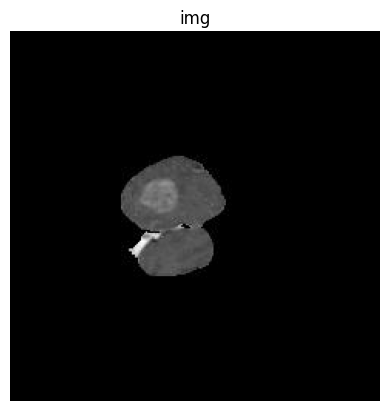

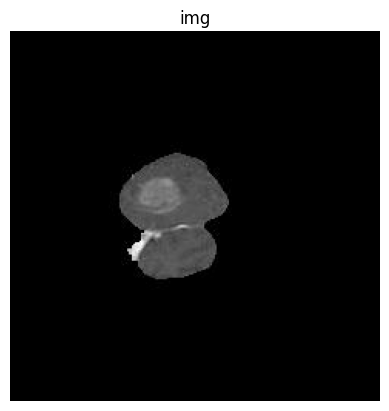

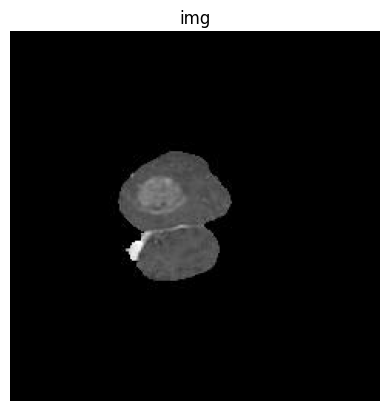

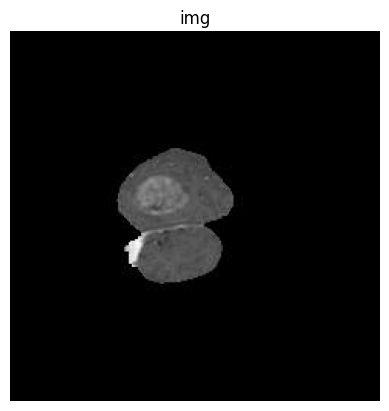

In [10]:
Sanity_check = True
if Sanity_check:
    image_frames, mask_frames, random_points_all, labels_for_points = read_batch(train_df)
    print(image_frames.shape)
    print(mask_frames.shape)
    print(len(random_points_all))
    print(len(labels_for_points))

    print(random_points_all[0])

    visualize_data(image_frames, mask_frames, random_points_all, labels_for_points)

    for i in range(0,10):
      plt.imshow(image_frames[i])
      plt.title('img')
      plt.axis('off')  # Ukryj osie
      plt.show()

    #  plt.imshow(mask_frames[i])
    #  plt.title('mask')
    #  plt.axis('off')  # Ukryj osie
    #  plt.show()

In [11]:
# Define batch size and other configurations
num_epochs = 1
loss_history = []
iou_history = []
FINE_TUNED_MODEL_NAME = "sam_2_fine_tuned_for_brain_tumour_segmentation"

# Move model to GPU
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.to(device)

# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(False)

# Configure optimizer
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=0.0001, weight_decay=4e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)

scaler = torch.cuda.amp.GradScaler()

# Number of gradient accumulation steps
gradient_accumulation_steps = 16
accumulation_step = 0

In [12]:
torch.cuda.empty_cache()

In [13]:
def read_batch(data, _=None):
    """
    For a given index, load the image and its corresponding mask and points.
    """
    ent = data.iloc[np.random.randint(len(data))]

    # Construct paths for the image and corresponding mask frames
    img_dir = ent["image"]
    mask_dir = ent["annotation"]

    # Load all frame files in the folder and sort by filename
    img_frames = natsorted(os.listdir(img_dir))
    msk_frames = natsorted(os.listdir(mask_dir))

    # Strip extensions to find matching base filenames
    img_basenames = {os.path.splitext(f)[0]: f for f in img_frames}
    mask_basenames = {os.path.splitext(f)[0]: f for f in msk_frames}

    # Find the intersection of base filenames
    matching_frames = natsorted(set(img_basenames.keys()).intersection(mask_basenames.keys()))

    # If no matching frames, return None
    if not matching_frames:
        print(f"Error: No matching frames found in {img_dir} and {mask_dir}")
        return None

    # Initialize lists
    image_frames = []
    mask_frames = []
    random_points_all = []
    labels_for_points = []

    for frame_name in matching_frames:
        img_path = os.path.join(img_dir, (frame_name + ".jpeg"))
        mask_path = os.path.join(mask_dir, (frame_name + ".bmp"))

        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        ann_map = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        if img is None or ann_map is None:
            print(f"Error: Could not read image or mask from path {img_path} or {mask_path}")
            continue

        mask_channel_1 = []
        mask_channel_2 = []
        mask_channel_3 = []

        mask_channel_1.append(np.where(ann_map == 255, 1, 0))
        mask_channel_2.append(np.where(ann_map == 170, 1, 0))
        mask_channel_3.append(np.where(ann_map == 85, 1, 0))

        # Generate random points and labels for each mask channel
        random_points_1, labels_1 = select_random_points(mask_channel_1[-1], 1)
        random_points_2, labels_2 = select_random_points(mask_channel_2[-1], 2)
        random_points_3, labels_3 = select_random_points(mask_channel_3[-1], 3)

        random_points = random_points_1 + random_points_2 + random_points_3
        labels = labels_1 + labels_2 + labels_3

        if len(random_points) != len(labels):
            print("missmatch in the size of points and labels")
            continue  # Skip this frame or handle it differently

        # Combine all random points and labels
        random_points_all.append(random_points)
        labels_for_points.append(labels)

        image_frames.append(img)

        # Combine the masks for the current frame using the given weights
        # we are making sure that data that was used for points creation is the same data in masks_frames
        # in future this wont be needed
        for idx in range(len(mask_channel_1)):
            mask_frame = 255 * mask_channel_1[idx] + 170 * mask_channel_2[idx] + 85 * mask_channel_3[idx]
            mask_frames.append(mask_frame)

    # Convert to numpy arrays
    image_frames = np.array(image_frames)
    mask_frames = np.array(mask_frames)

    # Return image_frames and mask_frames instead of undefined variables
    return image_frames, mask_frames, random_points_all, labels_for_points

In [14]:
x = read_batch(train_df)
print(type(x[0]))
print(type(x[1]))
print(type(x[2]))
print(type(x[3]))

print(x[0].shape)
print(x[1].shape)
print(len(x[2]))
print(len(x[3]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
(66, 240, 240, 3)
(66, 240, 240)
66
66


In [ ]:
import torch
import torch.nn.functional as F

def compute_iou(prd_mask, gt_mask):
    """
    Oblicza IoU pomiędzy przewidywaną maską a rzeczywistą maską.

    Args:
    - prd_mask (torch.Tensor): Przewidywana maska binarna (H, W).
    - gt_mask (torch.Tensor): Prawdziwa maska binarna (H, W).

    Returns:
    - iou (float): Intersection over Union.
    """
    # Dopasuj wymiary GT mask do wymiarów prd_mask, jeśli są różne
    if gt_mask.shape != prd_mask.shape:
        gt_mask = F.interpolate(gt_mask.unsqueeze(0).unsqueeze(0), size=prd_mask.shape, mode='bilinear', align_corners=False).squeeze()

    # Binary masks
    prd_mask_bin = (prd_mask > 0.5).float()  # Zakładając, że prd_mask to wartości w zakresie [0, 1]
    gt_mask_bin = (gt_mask > 0.5).float()    # Tak samo dla gt_mask

    # Intersection i union
    intersection = (prd_mask_bin * gt_mask_bin).sum()
    union = prd_mask_bin.sum() + gt_mask_bin.sum() - intersection

    # Oblicz IoU, zabezpiecz przed dzieleniem przez 0
    iou = intersection / (union + 1e-6)
    return iou



def compute_seg_loss(prd_mask, gt_mask):
    """
    Oblicza stratę segmentacyjną (Binary Cross-Entropy).

    Args:
    - prd_mask (torch.Tensor): Przewidywana maska (H, W).
    - gt_mask (torch.Tensor): Prawdziwa maska binarna (H, W).

    Returns:
    - loss (torch.Tensor): Strata BCE.
    """
    gt_mask = gt_mask.float()  # Upewnij się, że maska GT jest w formacie float
    return F.binary_cross_entropy(prd_mask, gt_mask)

def compute_score_loss(prd_score, iou):
    """
    Oblicza stratę na podstawie różnicy między przewidywanym wynikiem a IoU.

    Args:
    - prd_score (torch.Tensor): Przewidywany wynik IoU.
    - iou (float): Obliczone IoU.

    Returns:
    - loss (torch.Tensor): Strata regresyjna (L1 Loss).
    """
    return F.l1_loss(prd_score, torch.tensor([iou], device=prd_score.device))



def compute_loss(prd_masks_batch, gt_masks_batch, prd_scores_batch, ious_batch, alpha=0.25):
    # Oblicz BCE (binary cross-entropy) dla masek
    prd_masks_bin = (prd_masks_batch).float()  # Przewidywane maski
    gt_masks_bin = gt_masks_batch.float()  # Rzeczywiste maski

    # Oblicz binary cross-entropy (BCE) loss
    bce_loss = F.binary_cross_entropy_with_logits(prd_masks_batch, gt_masks_bin)
    #print(f"BCE loss: {bce_loss.item()}")

    # Oblicz stratę na podstawie IoU
    iou_loss = 1 - ious_batch  # 1 - IoU, bo chcemy maksymalizować IoU
    #print(f"IoU loss: {iou_loss.mean().item()}")

    # Oblicz finalną stratę
    total_loss = alpha * bce_loss + (1 - alpha) * iou_loss.mean()
    #print(f"Total loss: {total_loss.item()}")

    return total_loss







In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Załóżmy, że masz już prd_masks_batch i gt_masks_batch (np. po zmianie rozmiaru)

# Funkcja pomocnicza do wyświetlania obrazu
def show_tensor_image(tensor, title="Image", cmap="gray"):
    # Sprawdzamy kształt tensora (zakładamy, że jest w formacie [batch_size, 1, H, W])
    image = tensor.squeeze(0)  # Zbijamy batch size
    image = image.squeeze(0)  # Zbijamy kanał (jeśli tylko jeden)

    # Konwertujemy tensor na numpy i normalizujemy
    image = image.cpu().detach().numpy()

    # Wyświetlamy
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')  # Ukryj osie
    plt.show()

In [ ]:
batch_size = 4  # Liczba ramek w jednej partii
epochs = 10
iterations = 1000

for epoch in range(epochs):
  epoch_loss = []
  epoch_iou = []
  for itr in range(iterations):
      with torch.cuda.amp.autocast():
          # Załaduj batch danych
          image_frames, mask_frames, random_points_all, labels_for_points = read_batch(train_df, itr)

          # Sprawdzenie, czy batch jest prawidłowy
          if image_frames is None or mask_frames is None or len(image_frames) == 0:
              continue

          num_frames = len(image_frames)
          batch_loss = 0.0
          batch_iou = 0.0

          # Podział na partie
          for batch_start in range(0, num_frames, batch_size):
              batch_end = min(batch_start + batch_size, num_frames)
              batch_images = image_frames[batch_start:batch_end]
              batch_masks = mask_frames[batch_start:batch_end]
              batch_points = random_points_all[batch_start:batch_end]
              batch_labels = labels_for_points[batch_start:batch_end]

              # Inicjalizacja zmiennych dla partii
              prd_masks_list, gt_masks_list, prd_scores_list, ious_list = [], [], [], []



              # Przetwarzanie ramek w partii
              for frame_idx, image in enumerate(batch_images):
                  image_pil = Image.fromarray(image)
                  predictor.set_image(image_pil)

                  mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                      batch_points[frame_idx], batch_labels[frame_idx], box=None, mask_logits=None, normalize_coords=True
                  )

                  with torch.no_grad():
                      sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                          points=(unnorm_coords, labels), boxes=None, masks=None
                      )

                  high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
                  low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                      image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                      image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                      sparse_prompt_embeddings=sparse_embeddings,
                      dense_prompt_embeddings=dense_embeddings,
                      multimask_output=True,
                      repeat_image=False,
                      high_res_features=high_res_features,
                  )

                  # Przewidywana maska i rzeczywista maska
                  prd_mask = torch.sigmoid(low_res_masks[:, 0])
                  gt_mask = torch.tensor(batch_masks[frame_idx].astype(np.float32)).cuda()

                  prd_mask = prd_mask.unsqueeze(1)
                  prd_mask = F.interpolate(prd_mask, size=(240, 240), mode='bilinear', align_corners=False)[0][0]

                  prd_masks_list.append(prd_mask)
                  gt_masks_list.append(gt_mask)
                  iou = compute_iou(prd_mask, gt_mask)
                  ious_list.append(iou)
                  prd_scores_list.append(prd_scores[0])
                  torch.cuda.empty_cache()

              # Połącz listy w tensory
              prd_masks_batch = torch.stack(prd_masks_list)
              gt_masks_batch = torch.stack(gt_masks_list)
              prd_scores_batch = torch.stack(prd_scores_list)
              ious_batch = torch.tensor(ious_list).cuda()

              # Oblicz stratę
              avg_iou = torch.mean(ious_batch).item()
              batch_iou += avg_iou
              #print(f"Average IoU for batch {batch_start // batch_size + 1}: {avg_iou:.4f}")

              batch_loss += compute_loss(prd_masks_batch, gt_masks_batch, prd_scores_batch, ious_batch)

          # Aktualizacja wag modelu
          optimizer.zero_grad()
          scaler.scale(batch_loss).backward()
          torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
          scaler.step(optimizer)
          scaler.update()
          scheduler.step()

          #batch avg iou
          batch_iou = batch_iou/(num_frames/batch_size)

          # Logowanie strat
          loss_history.append(batch_loss.item())
          print(f"Iteration {itr}, Loss: {batch_loss.item():.4f}, IoU: {batch_iou:.4f}")

  epoch_loss = sum(epoch_loss)/len(epoch_loss)
  epoch_iou = sum(epoch_iou)/len(epoch_iou)

  print("="*20)
  print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}")
  print("="*20)


Iteration 0, Loss: 3.5579, IoU: 0.0005
Iteration 1, Loss: 3.6937, IoU: 0.0005
Iteration 2, Loss: 2.7247, IoU: 0.0560
Iteration 3, Loss: 3.5446, IoU: 0.0055
Iteration 4, Loss: 3.7022, IoU: 0.0000
Iteration 5, Loss: 2.8850, IoU: 0.0461
Iteration 6, Loss: 3.5659, IoU: 0.0022
Iteration 7, Loss: 3.7077, IoU: 0.0000
Iteration 8, Loss: 2.8743, IoU: 0.0591
Iteration 9, Loss: 3.5711, IoU: 0.0002
Iteration 10, Loss: 3.6533, IoU: 0.0023
Iteration 11, Loss: 2.7571, IoU: 0.0465
Iteration 12, Loss: 3.0512, IoU: 0.0236
Iteration 13, Loss: 2.9683, IoU: 0.0809
Iteration 14, Loss: 3.3645, IoU: 0.0524
Iteration 15, Loss: 3.3465, IoU: 0.0118
Iteration 16, Loss: 2.9923, IoU: 0.0413
Iteration 17, Loss: 3.6470, IoU: 0.0066
Iteration 18, Loss: 3.2691, IoU: 0.0162
Iteration 19, Loss: 2.8899, IoU: 0.0425
Iteration 20, Loss: 3.5045, IoU: 0.0275
Iteration 21, Loss: 3.5261, IoU: 0.0143
Iteration 22, Loss: 3.0945, IoU: 0.0374
Iteration 23, Loss: 3.5953, IoU: 0.0146
Iteration 24, Loss: 3.4213, IoU: 0.0383
Iteration 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
save_path = 'data/sam_2_fine_tuned_for_brain_tumour_segmentation.pt'


torch.save(predictor.model.state_dict(), save_path)

print(f'Model saved to {save_path}')